In [638]:
import pandas as pd
import requests
import json
from bs4 import BeautifulSoup
from time import sleep
import random
import plotly.graph_objs as go

In [18]:
# Combine all Uber Movement datasets for Nairobi 2019, speed data

quarter_1 = pd.read_csv(r'Downloads/movement-speeds-quarterly-by-hod-nairobi-2019-Q1.csv')
quarter_2 = pd.read_csv(r'Downloads/movement-speeds-quarterly-by-hod-nairobi-2019-Q2.csv')
quarter_3 = pd.read_csv(r'Downloads/movement-speeds-quarterly-by-hod-nairobi-2019-Q3.csv')
quarter_4 = pd.read_csv(r'Downloads/movement-speeds-quarterly-by-hod-nairobi-2019-Q4.csv')

speeds_2019 = pd.concat([quarter_1, quarter_2, quarter_3, quarter_4])

speeds_2019.head(5)

In [3]:
print('There are', len(list(speeds_2019['osm_way_id'].unique())), 'api requests to make.')

There are 5602 api requests to make.


In [4]:
# pull data (including road name, road type, one way street status, and surface type of road) from Open Street Map API Using OSM Way IDs, read out as dictionary
# Note that the OSM API kicked me out after 378 hits (web scraping is not allowed) this data is saved below. 


osms = list(speeds_2019['osm_way_id'].unique())

road_name = {}
road_type = {}
one_way = {}
surface = {}

for idx, osm in enumerate(osms):
    if idx%150 == 0:
        print('Requests completed:', idx)
    url = 'https://www.openstreetmap.org/api/0.6/way/{}.json'.format(osm)
    res = requests.get(url)
    if res.status_code <= 400:
        res.raise_for_status()
        way_id_dict = json.loads(res.text)
        elements_list = way_id_dict['elements']
        elements = elements_list[0]
        tags_dict = elements['tags']
        name_of_road = tags_dict.get('name')
        type_of_road = tags_dict.get('highway')
        one_way_status = tags_dict.get('oneway')
        road_surface = tags_dict.get('surface')
        road_name.setdefault(osm, name_of_road)
        road_type.setdefault(osm, type_of_road)
        one_way.setdefault(osm, one_way_status)
        surface.setdefault(osm, road_surface)
        sleep(5)

print(idx)

Requests completed: 0
Requests completed: 150
Requests completed: 300


ConnectionError: HTTPSConnectionPool(host='www.openstreetmap.org', port=443): Max retries exceeded with url: /api/0.6/way/26723454.json (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x119746210>: Failed to establish a new connection: [Errno 50] Network is down'))

In [6]:
# Convert all dictionaries to data frames 

roadname_df = pd.DataFrame.from_dict([road_name]).transpose()
roadtype_df = pd.DataFrame.from_dict([road_type]).transpose()
oneway_df = pd.DataFrame.from_dict([one_way]).transpose()
surface_df = pd.DataFrame.from_dict([surface]).transpose()

In [7]:
# rename index of data frame 

roadname_df2 = roadname_df.reset_index().rename(columns={0:"road_name", "index": "osm_way_id"})

roadtype_df2 = roadtype_df.reset_index().rename(columns={0:"road_yype", "index": "osm_way_id"})

oneway_df2 = oneway_df.reset_index().rename(columns={0:"one_way", "index": "osm_way_id"})

surface_df2 = surface_df.reset_index().rename(columns={0:"surface", "index": "osm_way_id"})

In [8]:
# Merge data frames 

roads1 = pd.merge(roadname_df2, roadtype_df2, left_on='osm_way_id', right_on="osm_way_id")
roads2 = pd.merge(oneway_df2, surface_df2, left_on='osm_way_id', right_on="osm_way_id")

roads_api = pd.merge(roads1, roads2, left_on='osm_way_id', right_on="osm_way_id")

roads_api.head(2)

roads_api.to_csv(r'/Users/allysonenglish/Desktop/Active/MARS/OSM_IDS_Round1.csv', index=False)

In [11]:
# merge data frames of OSM information with initial data from Movement and save as new file. 

Nairobi_osm_api = pd.merge(speeds_2019, roads_api, left_on='osm_way_id', right_on="osm_way_id")

In [12]:
# save new file as CSV. Also save the data frames from OSM information (did this twice because I happened to do it on two seperate occassions)

output_path = r'/Users/allysonenglish/Desktop/Active/MARS/Nairobi_osm_api.csv'
Nairobi_osm_api.to_csv(output_path, index=False)

roads_api.to_csv(r'/Users/allysonenglish/Desktop/Active/MARS/OSM_IDS_Round1.csv', index=False)
roads_api.to_csv(r'/Users/allysonenglish/Desktop/Active/MARS/OSM_dictionaries_1_378.csv', index=False)

In [130]:
# Of the OSM Way IDs collected, how many of these are in the top 100? Collected list shows what I have on file, top 100 list shows the top 100 from the dataset

collected = osms[:378]

freq_of_osm_ids = speeds_2019['osm_way_id'].value_counts()[:100]
top_100_osm_ids = []

for k in freq_of_osm_ids.keys():
    top_100_osm_ids.append(k)

In [143]:
# The top 100 OSM Way IDs account for 591,560 trips (the dataset itself is about 2M so this is about on quarter of the dataset). Calculated this by:
# (Saving new data frame from the top 100 most frequent osms in total dataset, then resetting index for ease of use and summing the data)

frequency_df = pd.DataFrame(freq_of_osm_ids)
frequency_count_df = frequency_df.reset_index().rename(columns={"index":"osm_way_id", "osm_way_id":"count"})
frequency_count_df.sum()

In [157]:
# Splits the osms I collected into two lists, those that are in the top 100 osms collected in the dataset and those which are not
# Checks to make sure that the osms collected that map to the top 100 and the 
# osms collected that do not map to the top 100 add up to 378, which was the amount I collected fromt he API (they do)

frequent_osms_collected = []
extra_osms_collected = []

for osm_collected in collected:
    if osm_collected not in top_100_osm_ids:
        extra_osms_collected.append(osm_collected)
    else:
        frequent_osms_collected.append(osm_collected)


len(extra_osms_collected) + len(frequent_osms_collected)

378

In [159]:
#lists the osms in the top 100 that I still need. 
# Checks to make sure that the osms collected in the top 100 and the osms still needed add up to 100

osms_still_needed = []

for osm_not_collected in top_100_osm_ids:
    if osm_not_collected not in collected:
        osms_still_needed.append(osm_not_collected)

len(osms_still_needed) + len(frequent_osms_collected)

# END

In [163]:
len(osms_still_needed)

47

In [172]:
#Getting the remaining 47 osm ids in the top 100:

road_name2 = {}
road_type2 = {}
one_way2 = {}
surface2 = {}

for idx, osm in enumerate(osms_still_needed):
    if idx%5 == 0:
        print('Requests completed:', idx)
    url = 'https://www.openstreetmap.org/api/0.6/way/{}.json'.format(osm)
    res = requests.get(url)
    if res.status_code <= 400:
        res.raise_for_status()
        way_id_dict = json.loads(res.text)
        elements_list = way_id_dict['elements']
        elements = elements_list[0]
        tags_dict = elements['tags']
        name_of_road = tags_dict.get('name')
        type_of_road = tags_dict.get('highway')
        one_way_status = tags_dict.get('oneway')
        road_surface = tags_dict.get('surface')
        road_name2.setdefault(osm, name_of_road)
        road_type2.setdefault(osm, type_of_road)
        one_way2.setdefault(osm, one_way_status)
        surface2.setdefault(osm, road_surface)
        s = random.randint(25, 62)
        sleep(s)
        

Requests completed: 0
Requests completed: 5
Requests completed: 10
Requests completed: 15
Requests completed: 20
Requests completed: 25
Requests completed: 30
Requests completed: 35
Requests completed: 40
Requests completed: 45


In [173]:
# Convert all dictionaries to data frames 

roadname_df3 = pd.DataFrame.from_dict([road_name2]).transpose()
roadtype_df3 = pd.DataFrame.from_dict([road_type2]).transpose()
oneway_df3 = pd.DataFrame.from_dict([one_way2]).transpose()
surface_df3 = pd.DataFrame.from_dict([surface2]).transpose()

In [231]:
# rename index of data frame 

roadname_df4 = roadname_df3.reset_index().rename(columns={0:"road_name", "index": "osm_way_id"})

roadtype_df4 = roadtype_df3.reset_index().rename(columns={0:"road_type", "index": "osm_way_id"})

oneway_df4 = oneway_df3.reset_index().rename(columns={0:"one_way", "index": "osm_way_id"})

surface_df4 = surface_df3.reset_index().rename(columns={0:"surface", "index": "osm_way_id"})

In [232]:
# Merge data frames 

roads3 = pd.merge(roadname_df4, roadtype_df4, left_on='osm_way_id', right_on="osm_way_id")
roads4 = pd.merge(oneway_df4, surface_df4, left_on='osm_way_id', right_on="osm_way_id")

roads_api2 = pd.merge(roads3, roads4, left_on='osm_way_id', right_on="osm_way_id")
roads_api2.head(2)

In [234]:
# merge data frames of OSM information with initial data from Movement and save as new file. 

Nairobi_osm_remaining_top = pd.merge(speeds_2019, roads_api2, left_on='osm_way_id', right_on="osm_way_id")

In [235]:
# save new file as CSV. Also save the data frames from OSM information

output_path = r'/Users/allysonenglish/Desktop/Active/MARS/Remaining_top_osms_Nairobi.csv'
Nairobi_osm_remaining_top.to_csv(output_path, index=False)

### Scrap working/ planning type of analysis to do 

In [236]:
len(Nairobi_osm_remaining_top)

226246

In [237]:
check_for_remaining_osms = list(Nairobi_osm_remaining_top['osm_way_id'].unique())

In [238]:
combined_datasets = pd.concat([Nairobi_osm_remaining_top, Nairobi_osm_api])
combined_datasets.drop('road_yype', axis=1, inplace = True)

In [239]:
len(combined_datasets)

800869

In [240]:
freq_ids_in_top = combined_datasets['osm_way_id'].value_counts()[:100]

In [241]:
top_ids = []

for k in freq_ids_in_top.keys():
    top_ids.append(k)

In [275]:
df2 = combined_datasets.groupby('road_name')['road_name'].value_counts()

In [279]:
type(df2)

pandas.core.series.Series

In [318]:
working_data_7_days = combined_datasets.drop(['segment_id', 'start_junction_id', 'end_junction_id', 'osm_start_node_id', 'osm_end_node_id', 'speed_kph_p50'], axis=1)

In [319]:
working_data_7_days.to_csv(r'/Users/allysonenglish/Desktop/Active/MARS/working_data_7_days.csv', index = False)

In [320]:
working_data_7_days.head()

,year,quarter,hour_of_day,osm_way_id,speed_kph_mean,speed_kph_stddev,speed_kph_p85,road_name,road_type,one_way,surface
0,2019,1,19,40317987,29.503,8.988,35.628,Mumias South Road,tertiary,None,None
1,2019,1,9,40317987,35.116,7.875,43.346,Mumias South Road,tertiary,None,None
2,2019,1,23,40317987,36.172,8.356,43.782,Mumias South Road,tertiary,None,None
3,2019,1,13,40317987,33.293,11.836,41.058,Mumias South Road,tertiary,None,None
4,2019,1,6,40317987,36.660,10.839,44.905,Mumias South Road,tertiary,None,None


In [315]:
working_data_7_days.groupby('road_name')['speed_kph_mean'].describe()

,count,mean,std,min,25%,50%,75%,max
road_name,,,,,,,,
1st Ngong Avenue,448.0,21.695480,4.220722,10.634,19.50000,21.9770,24.34425,40.115
1st Parklands Avenue,2037.0,32.224387,4.829897,15.994,29.20700,32.5170,35.59300,46.927
3rd Avenue Ngong,194.0,19.459861,2.128921,15.913,17.78050,18.8400,20.99325,25.482
Acacia Main Feeder Road,13.0,17.694692,2.060723,13.769,17.01000,18.1290,18.80100,21.089
Airport North Road,1231.0,44.504297,13.053598,14.641,36.49950,43.8250,52.93600,73.466
...,...,...,...,...,...,...,...,...
Wangunyu Road,5.0,13.339400,1.815941,11.745,11.78700,12.8680,14.29100,16.006
Westlands Red Hill Road,282.0,62.646067,5.918389,48.504,60.96025,63.9185,66.87225,71.304
Westlands Road,1978.0,24.982488,5.741702,9.115,20.87900,24.9675,29.01750,45.669


In [403]:
most_popular_roads = working_data_7_days[['road_name','speed_kph_mean']].groupby(['road_name'])['speed_kph_mean'] \
                            .count() \
                            .reset_index(name='count') \
                            .sort_values(['count'], ascending=False) \
                            .head(15)

In [451]:
most_popular_roads['road_name']

121                  Limuru Road
80                 Kangundo Road
128                  Magadi Road
35                Eastern Bypass
79                   Kamiti Road
170                   Ngong Road
46              Forest Line Road
57                   Gitaru Road
93                   Kiambu Road
29                Dagoretti Road
55                Getathuru Road
124            Lower Kabete Road
97     Kihara-Gachie-Karura Road
12                     Boma Road
172              Northern Bypass
Name: road_name, dtype: object

In [406]:
most_popular_roads['count'].sum()

284796

In [507]:
subset_df_names

['LimuruRoad',
 'KangundoRoad',
 'MagadiRoad',
 'EasternBypass',
 'KamitiRoad',
 'NgongRoad',
 'ForestLineRoad',
 'GitaruRoad',
 'KiambuRoad',
 'DagorettiRoad',
 'GetathuruRoad',
 'LowerKabeteRoad',
 'Kihara-Gachie-KaruraRoad',
 'BomaRoad',
 'NorthernBypass']

In [501]:
subset_df_names = []
popular_road_dict = {}

for name in most_popular_roads['road_name']:

    bool_mask = working_data_7_days['road_name'].str.contains(name)
    bool_mask = bool_mask.fillna(False)
    
    name = name.replace(' ','')
    subset_df_names.append(name)
    
    popular_road_dict.setdefault(name, working_data_7_days[bool_mask])
    

In [511]:
for rd_name, df in popular_road_dict.items():
    print(rd_name)
    display(df.groupby('hour_of_day')['speed_kph_mean'].describe())
    print('\n\n')

LimuruRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,1954.0,45.691633,10.238275,13.611,39.63175,46.8275,52.98550,74.429
1,1852.0,46.687529,10.423705,14.332,40.62225,47.4925,53.63925,73.947
2,1543.0,45.290056,9.729029,15.022,39.76050,47.0590,52.15850,67.355
3,1230.0,45.043243,9.688302,15.083,39.43850,46.7030,51.72875,68.496
4,1573.0,46.854442,10.872560,15.634,40.87400,47.5610,53.21400,81.181
5,1706.0,45.179462,9.705974,15.090,39.90000,46.3080,51.38975,71.967
6,2046.0,44.957412,10.682450,13.035,38.50400,45.2640,52.69150,69.747
7,2200.0,45.042610,11.734496,12.360,37.41275,45.4500,54.09050,76.903
8,2435.0,45.921639,13.027500,11.292,37.03550,46.2410,55.37150,82.850





KangundoRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,1290.0,42.209078,11.427974,16.472,32.40325,42.8390,51.78675,68.854
1,1127.0,42.840492,11.710937,17.235,33.17050,43.6070,51.88600,72.554
2,1043.0,42.439594,11.641094,16.507,32.18300,43.1170,51.70300,68.871
3,764.0,41.027501,10.888691,16.836,31.47650,42.1940,49.33075,68.357
4,977.0,42.897288,11.466512,16.783,33.09800,44.0620,52.09800,68.723
5,987.0,40.609779,11.169153,16.859,31.84100,41.1610,49.38250,67.677
6,1074.0,40.447112,12.490020,15.240,30.09825,40.1105,50.52325,71.913
7,1207.0,39.576830,12.878813,14.141,29.43400,39.1420,50.75700,74.041
8,1270.0,38.465948,12.955421,12.933,27.66025,38.1540,49.42075,73.245





MagadiRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,1184.0,43.420556,6.907329,20.787,39.03650,44.2475,48.31175,64.632
1,1175.0,44.813249,6.955197,22.811,40.44650,45.6020,49.61100,65.120
2,1034.0,45.155083,6.992063,23.426,41.08050,45.4615,49.95550,64.134
3,742.0,44.261225,6.840772,22.494,40.25875,44.4340,49.02125,65.559
4,1047.0,46.312255,7.905069,23.088,41.45550,46.1570,52.14950,68.207
5,1149.0,42.330560,8.227288,20.995,36.73500,43.0800,48.10000,64.764
6,1132.0,39.930192,9.862817,17.163,31.66625,41.6330,47.31700,64.361
7,1181.0,38.546465,9.952253,14.969,30.24400,40.2060,45.99600,63.300
8,1181.0,36.646795,10.824188,12.764,27.79800,38.4820,44.88100,63.171





EasternBypass


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,748.0,57.643729,10.243689,26.077,52.51725,58.0165,65.38075,77.991
1,748.0,59.250811,10.404522,26.991,53.94100,59.9910,67.21100,78.800
2,748.0,60.583305,10.830765,26.510,55.65000,61.1420,68.68025,80.397
3,745.0,61.217026,11.092786,25.852,56.42200,61.7970,69.81300,82.936
4,748.0,61.071059,10.490663,25.914,56.87775,61.9455,68.70525,79.012
5,748.0,56.912922,10.434059,25.472,51.19000,57.3725,65.33925,75.454
6,748.0,52.284666,11.253262,22.846,44.38050,54.1580,60.84450,74.418
7,748.0,46.104591,10.977583,16.985,38.54150,47.1065,54.61625,69.033
8,748.0,44.652201,10.641616,15.686,37.48350,45.2955,53.15450,66.135





KamitiRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,1095.0,39.960062,11.646441,14.050,31.30550,38.8570,47.88050,69.109
1,1090.0,40.420585,11.624227,14.526,31.65550,39.7295,48.22600,69.920
2,1013.0,40.917333,11.958444,13.637,31.87300,39.6810,49.48200,72.229
3,584.0,39.303507,12.325763,14.507,30.25100,38.0105,49.07900,68.838
4,777.0,40.391770,11.795572,15.131,31.45600,39.1520,49.52800,70.566
5,935.0,39.947298,12.146556,14.459,31.05700,38.7500,47.76800,74.988
6,1015.0,41.343915,13.492847,15.495,30.94600,39.8610,52.47500,75.155
7,1096.0,40.405345,12.997482,14.466,30.69350,39.2985,50.14200,72.723
8,1096.0,39.077609,13.192726,12.668,28.88700,37.4970,48.85075,70.935





NgongRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,720.0,42.070314,9.912025,15.291,35.11500,44.7930,49.48375,57.642
1,716.0,43.204176,10.131511,14.450,36.61325,46.1140,50.78575,57.793
2,669.0,45.081846,9.277745,16.084,39.94500,47.1690,51.68200,59.266
3,614.0,46.691433,8.557742,16.705,42.62975,48.8020,53.11200,60.304
4,692.0,45.398275,10.347468,16.044,38.70400,47.9555,53.68300,63.239
5,720.0,42.060969,10.273390,15.965,33.46525,45.0615,49.76975,59.618
6,720.0,36.975933,9.823496,13.152,28.92950,38.2775,44.43825,60.487
7,720.0,34.021326,9.409251,13.140,26.27325,33.2120,41.79850,55.945
8,720.0,33.003772,9.727179,12.755,24.88625,31.8645,42.00000,53.950





ForestLineRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,751.0,36.542999,10.055576,14.130,28.60200,35.2700,43.96800,62.736
1,452.0,36.493208,9.871228,14.392,28.99625,36.2100,43.50125,59.084
2,214.0,39.802874,11.053304,14.286,31.24200,39.9025,48.71825,59.979
4,175.0,41.431063,10.857384,15.203,32.40600,41.5680,49.32250,63.114
5,232.0,42.305522,11.610101,14.311,33.36875,41.9555,51.94675,62.901
6,478.0,37.492494,10.607048,15.014,28.54425,37.6690,46.31800,57.995
7,693.0,36.817286,11.554926,14.675,26.83600,35.7620,45.80700,64.397
8,732.0,34.864956,10.591748,14.810,26.12225,33.3925,42.83800,62.014
9,784.0,34.526320,10.801973,12.949,25.74500,33.3535,42.31250,61.846





GitaruRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,757.0,38.681472,10.396021,13.068,30.27300,40.5680,47.12500,59.800
1,732.0,40.026432,10.705425,14.162,31.37875,41.8085,48.47775,60.850
2,661.0,41.073440,10.840924,16.777,32.51200,43.3150,49.60700,63.017
3,308.0,42.828734,10.141969,14.300,36.32400,45.0695,50.61200,60.224
4,588.0,41.008236,10.518500,12.608,31.88475,42.9455,48.98350,62.547
5,680.0,39.887540,10.738152,12.521,30.92175,41.6370,48.47975,62.145
6,768.0,38.408611,10.993107,9.713,28.51100,39.6500,47.41225,69.687
7,934.0,37.614449,11.235127,8.861,28.21675,38.2295,46.73100,75.108
8,1003.0,37.280898,11.126989,9.386,27.99550,38.1380,45.82100,73.254





KiambuRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,627.0,44.889410,10.287215,18.062,37.56450,46.4040,52.76900,65.449
1,621.0,45.358523,10.068428,17.013,38.10800,47.1760,52.90800,65.778
2,539.0,44.865293,10.014538,16.970,38.05050,46.4550,52.47050,65.951
3,447.0,44.592058,9.599279,21.445,37.36550,46.9650,51.85250,67.232
4,491.0,46.185921,10.599735,18.008,38.38250,47.8990,53.79750,66.871
5,491.0,44.760069,9.836455,22.415,37.79400,46.1550,51.41750,64.920
6,492.0,42.302911,9.948789,16.916,34.48275,43.9975,49.61825,64.639
7,501.0,40.222629,10.000511,17.053,32.60700,41.2900,46.92500,63.305
8,516.0,38.738839,9.750358,16.455,31.42400,39.5090,45.41775,60.603





DagorettiRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,494.0,47.791538,9.943112,18.091,42.14275,50.2890,55.07700,67.708
1,415.0,48.720219,9.960261,20.926,43.02450,51.7040,55.94000,66.751
2,312.0,47.570788,9.513064,19.183,42.56775,49.2220,54.59975,64.773
3,69.0,50.651812,6.562324,24.202,47.45600,51.8150,54.48600,61.719
4,264.0,48.197996,10.003723,22.059,42.40925,50.7025,56.20300,65.895
5,294.0,46.967629,10.756643,18.856,40.66125,49.2090,54.89200,68.347
6,427.0,48.450307,12.102701,15.514,42.52350,51.7780,57.74850,68.153
7,524.0,47.251941,11.251732,15.405,41.83900,49.8975,55.61600,65.570
8,598.0,47.081112,10.932433,13.749,41.44200,49.6415,55.07375,67.134





GetathuruRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,544.0,45.854533,8.516622,21.430,40.99850,47.8875,52.18425,61.306
1,544.0,46.992454,9.116142,22.826,41.32325,49.0835,53.40050,64.109
2,544.0,48.348653,9.949599,22.762,42.08175,49.8135,55.80725,67.995
3,384.0,46.716052,8.845560,21.826,41.50475,48.5490,53.58225,61.516
4,544.0,47.766156,9.995325,23.244,40.97600,48.6080,56.03425,66.758
5,544.0,46.755535,9.411995,21.365,41.29850,47.9500,52.99075,66.021
6,544.0,47.500829,9.459194,19.123,42.13500,49.5230,54.93225,64.439
7,544.0,48.318119,9.752504,21.755,42.39925,50.5950,55.60725,64.562
8,544.0,48.234075,9.623510,22.450,42.25850,50.5835,55.88625,63.758





LowerKabeteRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,520.0,41.348556,9.014297,18.228,34.81750,43.1815,48.23325,61.093
1,520.0,42.028456,9.330475,18.603,35.17200,43.4695,48.88600,59.008
2,518.0,42.153097,9.094405,18.440,35.17475,44.2960,49.13250,59.549
3,434.0,42.917576,10.055268,18.928,35.20975,45.1335,50.17750,66.657
4,520.0,43.654669,10.174463,18.321,35.31500,45.0585,51.35950,67.998
5,520.0,43.673648,10.502040,20.207,35.54475,44.0685,51.19925,68.638
6,520.0,43.984348,10.680722,18.271,35.82675,43.8700,52.37275,65.867
7,520.0,42.986992,11.035404,18.895,34.05925,42.7655,52.02150,67.266
8,520.0,42.775088,11.003729,18.996,33.81550,42.0075,51.81450,66.797





Kihara-Gachie-KaruraRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,227.0,31.011374,6.927660,14.503,25.97900,31.1240,35.69200,49.652
1,122.0,29.249107,4.751531,18.741,25.03825,30.2780,32.87375,37.977
2,87.0,29.550828,4.048071,20.426,26.32800,30.0890,32.58850,37.313
4,65.0,27.902815,4.654137,18.280,24.18200,28.2310,30.67700,38.570
5,73.0,28.312315,5.522558,16.723,24.41300,28.4550,33.09700,38.422
6,317.0,33.273536,8.808652,13.904,27.44600,32.5510,39.24400,55.534
7,467.0,35.785368,11.067799,11.563,27.84500,34.4690,44.16300,58.924
8,593.0,37.422688,11.095799,13.929,29.81200,35.7840,46.20200,60.008
9,708.0,36.451880,11.474105,11.915,28.40525,34.6550,45.20850,62.966





BomaRoad


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,263.0,40.093825,8.797357,12.895,35.54100,41.6870,46.97050,55.395
1,122.0,39.738041,9.455454,16.988,33.74975,41.0455,47.13000,56.321
2,75.0,37.314133,9.387125,17.787,31.25650,38.1590,44.76900,52.976
3,21.0,42.793095,6.354327,26.640,38.55200,42.0420,47.23400,52.673
4,92.0,39.612402,9.321579,16.393,34.45425,42.1950,46.79200,56.295
5,169.0,43.560178,11.236028,14.566,35.82300,45.5410,51.92400,71.967
6,160.0,45.406213,12.283909,12.492,38.02625,46.7290,51.64975,73.871
7,503.0,46.257650,12.152580,14.131,38.10500,48.9900,55.50650,71.309
8,662.0,45.064005,11.215245,13.493,36.92250,46.8755,53.84650,68.844





NorthernBypass


,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,496.0,54.072232,14.342897,16.405,49.25675,58.8105,63.89550,75.516
1,496.0,55.256962,14.708706,16.005,50.24525,59.6850,65.55500,77.650
2,496.0,55.675764,15.029206,15.909,49.75200,60.6745,66.33700,76.984
3,496.0,55.991708,15.197609,15.579,50.60975,60.5940,66.75350,77.388
4,496.0,56.755155,15.369962,16.624,51.15625,62.1470,67.61400,79.443
5,496.0,55.191595,14.634710,16.504,50.05125,60.2845,65.18350,75.893
6,496.0,51.905871,14.159806,16.782,46.83900,56.1965,61.77975,74.338
7,496.0,49.926067,14.169395,15.975,44.77350,54.7950,59.40825,72.022
8,496.0,49.735831,13.702304,16.238,44.92875,54.3820,59.28050,71.122


In [1]:
popular_road_dict['LimuruRoad'].groupby('hour_of_day')['speed_kph_p85'].describe()['mean'] - \
popular_road_dict['LimuruRoad'].groupby('hour_of_day')['speed_kph_mean'].describe()['mean']

NameError: name 'popular_road_dict' is not defined

In [510]:
popular_road_dict['GetathuruRoad'].groupby('hour_of_day')['speed_kph_mean'].describe()

,count,mean,std,min,25%,50%,75%,max
hour_of_day,,,,,,,,
0,544.0,45.854533,8.516622,21.430,40.99850,47.8875,52.18425,61.306
1,544.0,46.992454,9.116142,22.826,41.32325,49.0835,53.40050,64.109
2,544.0,48.348653,9.949599,22.762,42.08175,49.8135,55.80725,67.995
3,384.0,46.716052,8.845560,21.826,41.50475,48.5490,53.58225,61.516
4,544.0,47.766156,9.995325,23.244,40.97600,48.6080,56.03425,66.758
5,544.0,46.755535,9.411995,21.365,41.29850,47.9500,52.99075,66.021
6,544.0,47.500829,9.459194,19.123,42.13500,49.5230,54.93225,64.439
7,544.0,48.318119,9.752504,21.755,42.39925,50.5950,55.60725,64.562
8,544.0,48.234075,9.623510,22.450,42.25850,50.5835,55.88625,63.758


In [505]:
popular_road_dict['LimuruRoad'].describe()

,year,quarter,hour_of_day,osm_way_id,speed_kph_mean,speed_kph_stddev,speed_kph_p85
count,54511.0,54511.000000,54511.000000,5.451100e+04,54511.000000,54511.000000,54511.000000
mean,2019.0,2.527233,12.337968,1.817337e+08,43.579563,11.313579,52.860471
std,0.0,1.119869,6.560575,1.229872e+08,12.151726,2.704768,13.505080
min,2019.0,1.000000,0.000000,2.402738e+07,6.491000,2.515000,8.789000
25%,2019.0,2.000000,7.000000,5.305909e+07,35.407500,9.612000,43.985000
50%,2019.0,3.000000,13.000000,2.315038e+08,44.195000,11.151000,53.725000
75%,2019.0,4.000000,18.000000,2.315038e+08,52.115500,12.814000,62.433000
max,2019.0,4.000000,23.000000,6.437218e+08,85.344000,32.145000,98.124000


In [496]:
subset_df_names

['LimuruRoad',
 'KangundoRoad',
 'MagadiRoad',
 'EasternBypass',
 'KamitiRoad',
 'NgongRoad',
 'ForestLineRoad',
 'GitaruRoad',
 'KiambuRoad',
 'DagorettiRoad',
 'GetathuruRoad',
 'LowerKabeteRoad',
 'Kihara-Gachie-KaruraRoad',
 'BomaRoad',
 'NorthernBypass']

In [485]:
'this_is_a_test_{}'.format(position)

'this_is_a_test_1'

In [337]:
# a boolean (true/false) mask  noting which rows contain 'Limuru Road' in the road_name column (others marked as 'false')
bool_mask = working_data_7_days['road_name'].str.contains("Limuru Road")

#If there are any missing values in the road_name column, this will fill 'NaN' values in bool_mask with 'False'
bool_mask = bool_mask.fillna(False)

#Creates a new dataframe called limuru_road wher
limuru_road = working_data_7_days[bool_mask]

In [577]:
limuru_road

,year,quarter,hour_of_day,osm_way_id,speed_kph_mean,speed_kph_stddev,speed_kph_p85,road_name,road_type,one_way,surface
120733,2019,1,18,493736707,10.552,5.751,14.285,Limuru Road,secondary,None,None
120734,2019,1,23,493736707,17.014,7.026,20.871,Limuru Road,secondary,None,None
120735,2019,1,7,493736707,14.899,8.725,19.602,Limuru Road,secondary,None,None
120736,2019,1,13,493736707,12.249,6.613,16.374,Limuru Road,secondary,None,None
120737,2019,1,15,493736707,11.876,8.679,15.318,Limuru Road,secondary,None,None
...,...,...,...,...,...,...,...,...,...,...,...
475012,2019,4,16,24027382,16.515,11.103,23.686,Limuru Road,NaN,yes,None
475013,2019,4,20,24027382,20.077,11.561,26.901,Limuru Road,NaN,yes,None
475014,2019,4,19,24027382,18.355,10.045,24.562,Limuru Road,NaN,yes,None
475015,2019,4,2,24027382,27.626,12.887,34.199,Limuru Road,NaN,yes,None


In [345]:
working_data_7_days.groupby('road_name')['speed_kph_mean'].describe().sort_values(['count'], ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
road_name,,,,,,,,
Limuru Road,54511.0,43.579563,12.151726,6.491,35.40750,44.1950,52.11550,85.344
Kangundo Road,31024.0,37.692830,12.487343,6.394,27.71200,37.8620,47.34900,74.504
Magadi Road,27585.0,36.717597,10.943538,9.149,29.26200,38.6760,44.65700,68.207
Eastern Bypass,17949.0,46.891324,13.655683,9.836,36.39000,47.7480,56.76000,82.936
Kamiti Road,16436.0,39.181560,14.401492,9.087,27.62650,37.9590,51.79975,75.155
Ngong Road,15495.0,36.040760,11.308767,7.208,27.27700,37.1790,44.86450,63.239
Forest Line Road,15487.0,34.064063,10.719337,10.824,25.58750,33.0390,41.88400,64.397
Gitaru Road,15343.0,37.029910,10.824972,7.377,28.17400,38.7280,45.51350,63.017
Kiambu Road,15238.0,40.961591,11.321845,12.815,32.41725,41.1545,50.05875,70.320


In [594]:


#                     'Average Speed': popular_road_dict['KangundoRoad'].groupby('hour_of_day')['speed_kph_p85']})

,year,quarter,hour_of_day,osm_way_id,speed_kph_mean,speed_kph_stddev,speed_kph_p85,road_name,road_type,one_way,surface
82373,2019,1,18,658223863,25.306,12.961,36.298,Kangundo Road,secondary,None,None
82374,2019,1,13,658223863,27.303,11.341,37.547,Kangundo Road,secondary,None,None
82375,2019,1,0,658223863,39.305,8.642,47.091,Kangundo Road,secondary,None,None
82376,2019,1,14,658223863,24.934,11.151,36.039,Kangundo Road,secondary,None,None
82377,2019,1,4,658223863,43.224,8.515,51.158,Kangundo Road,secondary,None,None
...,...,...,...,...,...,...,...,...,...,...,...
395217,2019,4,13,515077028,44.071,9.574,53.810,Kangundo Road,NaN,None,None
395218,2019,4,15,515077028,43.207,5.314,47.977,Kangundo Road,NaN,None,None
395219,2019,4,14,515077028,44.285,8.954,53.810,Kangundo Road,NaN,None,None
395220,2019,4,20,515077028,40.908,8.208,49.968,Kangundo Road,NaN,None,None


In [600]:
# Isolate Kangundo Road in popular_road_dict dictionary and group data by hour of day and convert into Data Frame 

KangundoRoad = popular_road_dict['KangundoRoad'].groupby('hour_of_day')
KangundoRoad = KangundoRoad.apply(pd.DataFrame)

In [646]:
KangundoRoad

,year,quarter,hour_of_day,osm_way_id,speed_kph_mean,speed_kph_stddev,speed_kph_p85,road_name,road_type,one_way,surface
82373,2019,1,18,658223863,25.306,12.961,36.298,Kangundo Road,secondary,None,None
82374,2019,1,13,658223863,27.303,11.341,37.547,Kangundo Road,secondary,None,None
82375,2019,1,0,658223863,39.305,8.642,47.091,Kangundo Road,secondary,None,None
82376,2019,1,14,658223863,24.934,11.151,36.039,Kangundo Road,secondary,None,None
82377,2019,1,4,658223863,43.224,8.515,51.158,Kangundo Road,secondary,None,None
...,...,...,...,...,...,...,...,...,...,...,...
395217,2019,4,13,515077028,44.071,9.574,53.810,Kangundo Road,NaN,None,None
395218,2019,4,15,515077028,43.207,5.314,47.977,Kangundo Road,NaN,None,None
395219,2019,4,14,515077028,44.285,8.954,53.810,Kangundo Road,NaN,None,None
395220,2019,4,20,515077028,40.908,8.208,49.968,Kangundo Road,NaN,None,None


In [595]:
KangundoRoad = KangundoRoad.apply(pd.DataFrame)

In [585]:
FFS = KangundoRoad.groupby('hour_of_day')['speed_kph_p85']

In [620]:
df2 = pd.DataFrame({'Free Flow Speed': KangundoRoad.groupby('hour_of_day')['speed_kph_p85'].describe()['mean'],
                    'Average Speeds': KangundoRoad.groupby('hour_of_day')['speed_kph_mean'].describe()['mean']})

In [636]:
df2['Proportional Diff'] = KangundoRoad.groupby('hour_of_day')['speed_kph_mean'].describe()['mean'] / KangundoRoad.groupby('hour_of_day')['speed_kph_p85'].describe()['mean']


In [ ]:
import plotly.graph_objs as go

In [641]:
df2 = df2.rename(columns={"Free Flow Speed":"FFS", "Average Speeds": "Avrg", "Proportional Diff": "Prop_diff"})

In [647]:
dftest = KangundoRoad.iloc

In [651]:
dftest = KangundoRoad.iloc

trace1 = go.Bar(
                x = dftest.hour_of_day,
                y = dftest.speed_kph_p85,
                name = "Free Flow Speed",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                text = dftest.road_name)

AttributeError: '_iLocIndexer' object has no attribute 'hour_of_day'

In [650]:
KangundoRoad

,year,quarter,hour_of_day,osm_way_id,speed_kph_mean,speed_kph_stddev,speed_kph_p85,road_name,road_type,one_way,surface
82373,2019,1,18,658223863,25.306,12.961,36.298,Kangundo Road,secondary,None,None
82374,2019,1,13,658223863,27.303,11.341,37.547,Kangundo Road,secondary,None,None
82375,2019,1,0,658223863,39.305,8.642,47.091,Kangundo Road,secondary,None,None
82376,2019,1,14,658223863,24.934,11.151,36.039,Kangundo Road,secondary,None,None
82377,2019,1,4,658223863,43.224,8.515,51.158,Kangundo Road,secondary,None,None
...,...,...,...,...,...,...,...,...,...,...,...
395217,2019,4,13,515077028,44.071,9.574,53.810,Kangundo Road,NaN,None,None
395218,2019,4,15,515077028,43.207,5.314,47.977,Kangundo Road,NaN,None,None
395219,2019,4,14,515077028,44.285,8.954,53.810,Kangundo Road,NaN,None,None
395220,2019,4,20,515077028,40.908,8.208,49.968,Kangundo Road,NaN,None,None


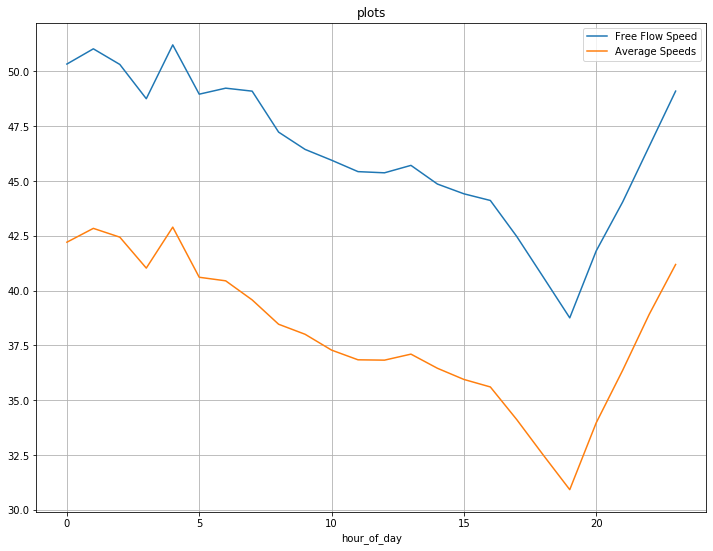

In [630]:
plot = df2.plot.line(rot= 0, figsize=(12, 9), grid=True, title="plots")

In [617]:
KangundoRoad.groupby('hour_of_day')['speed_kph_mean'].describe()['mean']

hour_of_day
0     42.209078
1     42.840492
2     42.439594
3     41.027501
4     42.897288
5     40.609779
6     40.447112
7     39.576830
8     38.465948
9     38.008190
10    37.285979
11    36.843258
12    36.827673
13    37.102325
14    36.457147
15    35.947473
16    35.604509
17    34.111471
18    32.496772
19    30.918531
20    33.968717
21    36.366763
22    38.912431
23    41.192986
Name: mean, dtype: float64

In [615]:
test['mean']

hour_of_day
0     42.209078
1     42.840492
2     42.439594
3     41.027501
4     42.897288
5     40.609779
6     40.447112
7     39.576830
8     38.465948
9     38.008190
10    37.285979
11    36.843258
12    36.827673
13    37.102325
14    36.457147
15    35.947473
16    35.604509
17    34.111471
18    32.496772
19    30.918531
20    33.968717
21    36.366763
22    38.912431
23    41.192986
Name: mean, dtype: float64

df2

In [377]:
limuru_road.groupby('hour_of_day')['speed_kph_mean'].describe()

In [513]:
df = pd.DataFrame({'Speed Limit': speed_limit,
                   'Actual Speeds': actual_speeds})

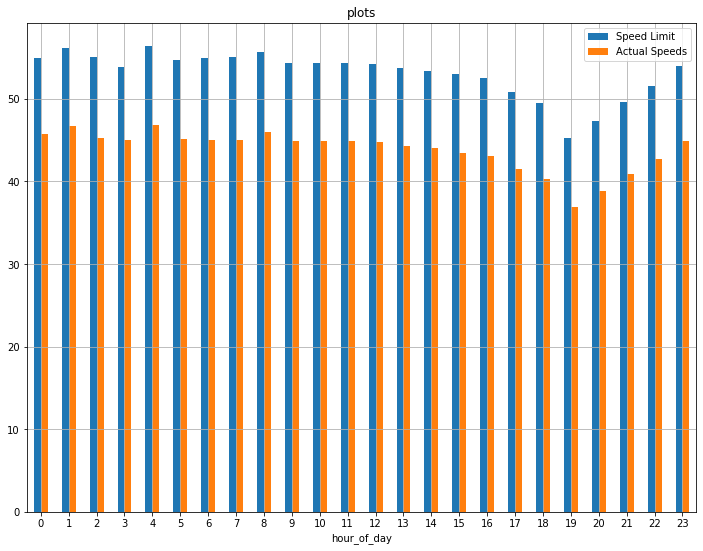

In [632]:
plot = df.plot.bar(rot=0, figsize=(12, 9), grid=True, title="plots")

In [387]:
speed_limit = limuru_speed_limit['mean']
actual_speeds = summarized_limurur_road

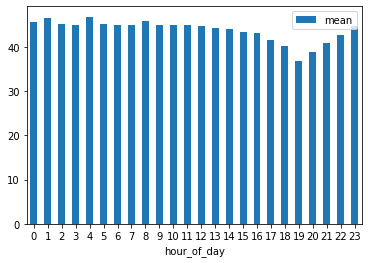

In [385]:
ax = summarized_limurur_road.plot.bar(y='mean', rot=0)

In [565]:
type(limuru_road['speed_kph_mean'])

pandas.core.series.Series

In [653]:
limuru_road

,year,quarter,hour_of_day,osm_way_id,speed_kph_mean,speed_kph_stddev,speed_kph_p85,road_name,road_type,one_way,surface
120733,2019,1,18,493736707,10.552,5.751,14.285,Limuru Road,secondary,None,None
120734,2019,1,23,493736707,17.014,7.026,20.871,Limuru Road,secondary,None,None
120735,2019,1,7,493736707,14.899,8.725,19.602,Limuru Road,secondary,None,None
120736,2019,1,13,493736707,12.249,6.613,16.374,Limuru Road,secondary,None,None
120737,2019,1,15,493736707,11.876,8.679,15.318,Limuru Road,secondary,None,None
...,...,...,...,...,...,...,...,...,...,...,...
475012,2019,4,16,24027382,16.515,11.103,23.686,Limuru Road,NaN,yes,None
475013,2019,4,20,24027382,20.077,11.561,26.901,Limuru Road,NaN,yes,None
475014,2019,4,19,24027382,18.355,10.045,24.562,Limuru Road,NaN,yes,None
475015,2019,4,2,24027382,27.626,12.887,34.199,Limuru Road,NaN,yes,None


In [656]:
test2 = limuru_road.iloc[1]

In [674]:
limuru_road.groupby('hour_of_day')['speed_kph_p85'].describe()['mean']

hour_of_day
0     54.876354
1     56.123364
2     55.011245
3     53.897695
4     56.389502
5     54.659931
6     54.939487
7     55.035752
8     55.609877
9     54.299261
10    54.352182
11    54.311060
12    54.211613
13    53.740330
14    53.417497
15    52.944950
16    52.475341
17    50.799031
18    49.458942
19    45.197005
20    47.340058
21    49.564313
22    51.565086
23    53.974620
Name: mean, dtype: float64

In [701]:
trace1 = go.Bar(
                x = hours,
                y = limuru_road.groupby('hour_of_day')['speed_kph_p85'].describe()['mean'],
                name = "Free Flow Speed",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)))

trace2 = go.Bar(
                x = hours,
                y = limuru_road.groupby('hour_of_day')['speed_kph_mean'].describe()['mean'],
                name = "Average Speed",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)))

data = [trace1, trace2]
layout = go.Layout(barmode = "group")
fig = go.Figure(data = data, layout = layout)
iplot(fig)

NameError: name 'iplot' is not defined

In [689]:
limuru_road['hour_of_day']

120733    18
120734    23
120735     7
120736    13
120737    15
          ..
475012    16
475013    20
475014    19
475015     2
475016     7
Name: hour_of_day, Length: 54511, dtype: int64

In [692]:
hours = []

for hour in limuru_road['hour_of_day']:
    if hour not in hours:
        hours.append(hour)
    

In [698]:
hours

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [702]:
from plotly.plotly import iplot

ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 


In [680]:
trace1 = go.Bar(
                x = limuru_road.groupby('hour_of_day')['speed_kph_mean'].describe()['mean'],
                y = limuru_road.groupby('hour_of_day')['speed_kph_p85'].describe()['mean'],
                name = "Free Flow Speed",
                marker = dict(color = 'rgba(255, 174, 255, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)))


Bar({
    'marker': {'color': 'rgba(255, 174, 255, 0.5)', 'line': {'color': 'rgb(0,0,0)', 'width': 1.5}},
    'name': 'Free Flow Speed',
    'x': array([45.69163255, 46.68752862, 45.29005574, 45.04324309, 46.85444183,
                45.17946249, 44.95741153, 45.04261   , 45.92163901, 44.90018917,
                44.92859908, 44.94412587, 44.81630775, 44.32332616, 44.05370882,
                43.42442703, 43.09817849, 41.51639917, 40.34115587, 36.83952603,
                38.8179301 , 40.92351571, 42.74299379, 44.85576391]),
    'y': array([54.87635415, 56.12336447, 55.01124498, 53.89769512, 56.38950223,
                54.65993142, 54.93948729, 55.03575227, 55.6098768 , 54.29926139,
                54.35218164, 54.31106003, 54.21161319, 53.74033039, 53.41749719,
                52.94495035, 52.47534113, 50.79903065, 49.45894245, 45.19700463,
                47.34005798, 49.56431253, 51.56508603, 53.97461992])
})

In [ ]:
# trace2 = go.Bar(
#                 x = test2.hour_of_day,
#                 y = test2.speed_kph_mean,
#                 name = "Average Speed",
#                 marker = dict(color = 'rgba(255, 255, 128, 0.5)',
#                               line=dict(color='rgb(0,0,0)',width=1.5)),
#                 text = test2.road_name)
# data = [trace1, trace2]
# layout = go.Layout(barmode = "group")
# fig = go.Figure(data = data, layout = layout)
# iplot(fig)